# Monitoring ML

Source: https://github.com/GokuMohandas/monitoring-ml/blob/main/monitoring.ipynb

## Setup

In [7]:
# High quality plots
%config InlineBackend.figure_format = "svg"

In [8]:
# Install Alibi (Seldon)
# !pip install alibi-detect

## Performance

In [9]:
# !pip install seaborn

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme()

In [11]:
# Generate data
hourly_f1 = list(np.random.randint(low=94, high=98, size=24*20)) + \
            list(np.random.randint(low=92, high=96, size=24*5)) + \
            list(np.random.randint(low=88, high=96, size=24*5)) + \
            list(np.random.randint(low=86, high=92, size=24*5))

In [12]:
# Cumulative f1 (tích luỹ)
cumulative_f1 = [np.mean(hourly_f1[:n]) for n in range(1, len(hourly_f1)+1)]
print (f"Average cumulative f1 on the last day: {np.mean(cumulative_f1[-24:]):.1f}")

Average cumulative f1 on the last day: 93.7


In [13]:
# Sliding f1
window_size = 24
sliding_f1 = np.convolve(hourly_f1, np.ones(window_size)/window_size, mode="valid")
print (f"Average sliding f1 on the last day: {np.mean(sliding_f1[-24:]):.1f}")

Average sliding f1 on the last day: 88.8


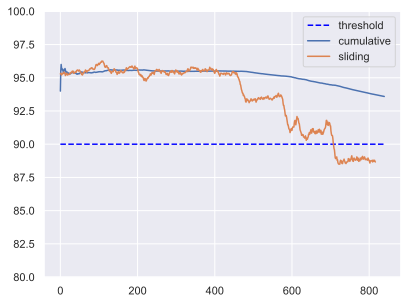

In [14]:
plt.ylim([80, 100])
plt.hlines(y=90, xmin=0, xmax=len(hourly_f1), colors="blue", linestyles="dashed", label="threshold")
plt.plot(cumulative_f1, label="cumulative")
plt.plot(sliding_f1, label="sliding")
plt.legend()

In [15]:
# Generate data

# dần dần 
gradual = list(np.random.uniform(96, 98, 20)) + \
          list(np.random.uniform(94, 96, 20)) + \
          list(np.random.uniform(92, 94, 20)) + \
          list(np.random.uniform(90, 92, 20))
          

# Đột ngột 
abrupt =  list(np.random.uniform(92, 94, 20)) + \
          list(np.random.uniform(90, 92, 20)) + \
          list(np.random.uniform(78, 80, 40))
          
# Định kỳ
periodic = list(np.random.uniform(87, 89, 15)) + \
           list(np.random.uniform(81, 85, 25)) + \
           list(np.random.uniform(87, 89, 15)) + \
           list(np.random.uniform(81, 85, 25))

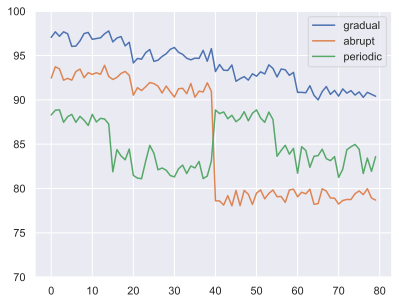

In [16]:
plt.ylim([70, 100])
plt.plot(gradual, label="gradual")
plt.plot(abrupt, label="abrupt")
plt.plot(periodic, label="periodic")
plt.legend()

## Data

In [17]:
# !pip install great-expectations

In [18]:
import great_expectations as ge
import json
import pandas as pd
from urllib.request import urlopen

In [19]:
# Load labeled projects
projects = pd.read_csv("https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/projects.csv")
tags = pd.read_csv("https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tags.csv")
df = ge.dataset.PandasDataset(pd.merge(projects, tags, on="id"))
df["text"] = df.title + " " + df.description
df.drop(["title", "description"], axis=1, inplace=True)
df.head(5)

,id,created_on,tag,text
0,6,2020-02-20 06:43:18,computer-vision,Comparison between YOLO and RCNN on real world...
1,7,2020-02-20 06:47:21,computer-vision,"Show, Infer & Tell: Contextual Inference for C..."
2,9,2020-02-24 16:24:45,graph-learning,Awesome Graph Classification A collection of i...
3,15,2020-02-28 23:55:26,reinforcement-learning,Awesome Monte Carlo Tree Search A curated list...
4,19,2020-03-03 13:54:31,graph-learning,Diffusion to Vector Reference implementation o...


## Expectations

In [20]:
# Simulated production data
prod_df = ge.dataset.PandasDataset([{"text": "hello"}, {"text": 0}, {"text": "world"}])

In [21]:
# Expectation suite
df.expect_column_values_to_not_be_null(column="text")
df.expect_column_values_to_be_of_type(column="text", type_="str")
expectation_suite = df.get_expectation_suite()

In [22]:
# Validate reference data
df.validate(expectation_suite=expectation_suite, only_return_failures=True)["statistics"]

{'evaluated_expectations': 2,
 'successful_expectations': 2,
 'unsuccessful_expectations': 0,
 'success_percent': 100.0}

In [23]:
# Validate production data
prod_df.validate(expectation_suite=expectation_suite, only_return_failures=True)["statistics"]

{'evaluated_expectations': 2,
 'successful_expectations': 1,
 'unsuccessful_expectations': 1,
 'success_percent': 50.0}

## Univariate

Drift detection on univariate data (dữ liệu đơn biến.)

### Kolmogorov-Smirnov (KS) test

KS test for detecting data drift on input sequence length. We can monitor aspects of our data that aren't necessarily inputs to the model (ex. length of input text).

In [24]:
from alibi_detect.cd import KSDrift

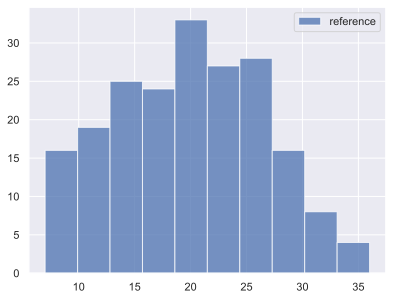

In [25]:
# Reference
df["num_tokens"] = df.text.apply(lambda x: len(x.split(" ")))
ref = df["num_tokens"][0:200].to_numpy()
plt.hist(ref, alpha=0.75, label="reference")
plt.legend()
plt.show()

In [26]:
# Initialize drift detector
length_drift_detector = KSDrift(ref, p_val=0.01)

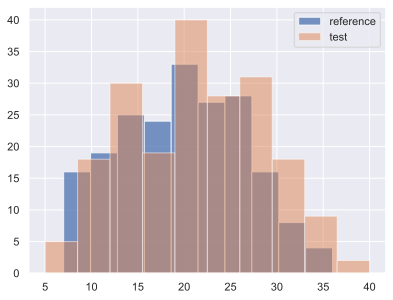

In [27]:
# No drift
no_drift = df["num_tokens"][200:400].to_numpy()
plt.hist(ref, alpha=0.75, label="reference")
plt.hist(no_drift, alpha=0.5, label="test")
plt.legend()
plt.show()

In [28]:
length_drift_detector.predict(no_drift, return_p_val=True, return_distance=True)

{'data': {'is_drift': 0,
  'distance': array([0.09], dtype=float32),
  'p_val': array([0.37063202], dtype=float32),
  'threshold': 0.01},
 'meta': {'name': 'KSDrift',
  'online': False,
  'data_type': None,
  'version': '0.11.2',
  'detector_type': 'drift'}}

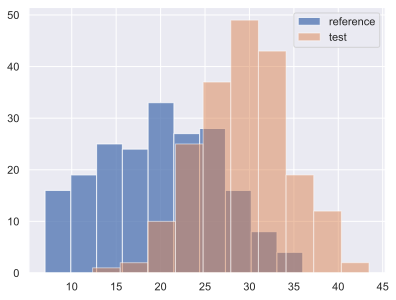

In [29]:
# Drift
drift = np.random.normal(30, 5, len(ref))
plt.hist(ref, alpha=0.75, label="reference")
plt.hist(drift, alpha=0.5, label="test")
plt.legend()
plt.show()

In [30]:
length_drift_detector.predict(drift, return_p_val=True, return_distance=True)

{'data': {'is_drift': 1,
  'distance': array([0.6], dtype=float32),
  'p_val': array([5.912822e-35], dtype=float32),
  'threshold': 0.01},
 'meta': {'name': 'KSDrift',
  'online': False,
  'data_type': None,
  'version': '0.11.2',
  'detector_type': 'drift'}}

### Chi-squared test
Detecting drift on categorical variables (can be used for data or target drift).

In [31]:
df.head(5)

,id,created_on,tag,text,num_tokens
0,6,2020-02-20 06:43:18,computer-vision,Comparison between YOLO and RCNN on real world...,28
1,7,2020-02-20 06:47:21,computer-vision,"Show, Infer & Tell: Contextual Inference for C...",36
2,9,2020-02-24 16:24:45,graph-learning,Awesome Graph Classification A collection of i...,16
3,15,2020-02-28 23:55:26,reinforcement-learning,Awesome Monte Carlo Tree Search A curated list...,17
4,19,2020-03-03 13:54:31,graph-learning,Diffusion to Vector Reference implementation o...,15


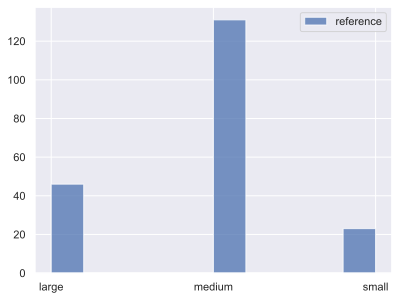

In [32]:
from alibi_detect.cd import ChiSquareDrift

# Reference
df.token_count = df.num_tokens.apply(lambda x: "small" if x <= 10 else ("medium" if x <=25 else "large"))
ref = df.token_count[0:200].to_numpy()
plt.hist(ref, alpha=0.75, label="reference")
plt.legend()

In [33]:
# Initialize drift detector
target_drift_detector = ChiSquareDrift(ref, p_val=0.01)

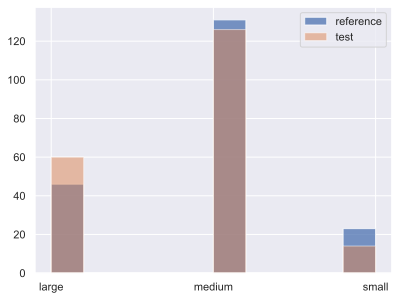

In [34]:
# No drift
no_drift = df.token_count[200:400].to_numpy()
plt.hist(ref, alpha=0.75, label="reference")
plt.hist(no_drift, alpha=0.5, label="test")
plt.legend()
plt.show()

In [35]:

target_drift_detector.predict(no_drift, return_p_val=True, return_distance=True)

{'data': {'is_drift': 0,
  'distance': array([4.135522], dtype=float32),
  'p_val': array([0.12646863], dtype=float32),
  'threshold': 0.01},
 'meta': {'name': 'ChiSquareDrift',
  'online': False,
  'data_type': None,
  'version': '0.11.2',
  'detector_type': 'drift'}}

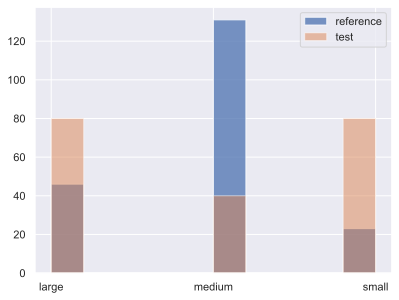

In [36]:
# Drift
drift = np.array(["small"]*80 + ["medium"]*40 + ["large"]*80)
plt.hist(ref, alpha=0.75, label="reference")
plt.hist(drift, alpha=0.5, label="test")
plt.legend()
plt.show()

In [37]:

target_drift_detector.predict(drift, return_p_val=True, return_distance=True)

{'data': {'is_drift': 1,
  'distance': array([89.145195], dtype=float32),
  'p_val': array([4.389017e-20], dtype=float32),
  'threshold': 0.01},
 'meta': {'name': 'ChiSquareDrift',
  'online': False,
  'data_type': None,
  'version': '0.11.2',
  'detector_type': 'drift'}}

### Multivariate
Drfit detection on multivariate data.

As we can see, measuring drift is fairly straightforward for univariate data but difficult for multivariate data. We'll summarize the reduce and measure approach outlined in the following paper: Failing Loudly: An Empirical Study of Methods for Detecting Dataset Shift.

![](https://camo.githubusercontent.com/2d17890ed8d6ebbcbd052f1d80e6e0a2e0c7cb90ba66cb38f2c1bdc0a6bd7691/68747470733a2f2f6d616465776974686d6c2e636f6d2f7374617469632f696d616765732f6d6c6f70732f6d6f6e69746f72696e672f6661696c696e675f6c6f75646c792e706e67)

In [38]:
# Reference
ref = df.text[0:200].to_list()

#### Embeddings

In [39]:
from transformers import AutoTokenizer

model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
vocab_size = len(tokenizer)
print (vocab_size)

31090


In [40]:
# Tokenize inputs
encoded_input = tokenizer(df.text.tolist(), return_tensors="pt", padding=True)
ids = encoded_input["input_ids"]
masks = encoded_input["attention_mask"]

In [41]:
# Decode
print (f"{ids[0]}\n{tokenizer.decode(ids[0])}")

tensor([  102,  2029,   467,  1778,   609,   137,  6446,  4857,   191,  1332,
         2399, 13572, 19125,  1983,   147,  1954,   165,  6240,   205,   185,
          300,  3717,  7434,  1262,   121,   537,   201,   137,  1040,   111,
          545,   121,  4714,   205,   103,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0])
[CLS] comparison between yolo and rcnn on real world videos bringing theory to experiment is cool. we can easily train models in colab and find the results in minutes. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [42]:
# Sub-word tokens
print (tokenizer.convert_ids_to_tokens(ids=ids[0]))

['[CLS]', 'comparison', 'between', 'yo', '##lo', 'and', 'rc', '##nn', 'on', 'real', 'world', 'videos', 'bringing', 'theory', 'to', 'experiment', 'is', 'cool', '.', 'we', 'can', 'easily', 'train', 'models', 'in', 'col', '##ab', 'and', 'find', 'the', 'results', 'in', 'minutes', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [43]:
from alibi_detect.models.pytorch import TransformerEmbedding

In [44]:
# Embedding layer
emb_type = "hidden_state"
layers = [-x for x in range(1, 9)]  # last 8 layers
embedding_layer = TransformerEmbedding(model_name, emb_type, layers)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [45]:
# Embedding dimension
embedding_dim = embedding_layer.model.embeddings.word_embeddings.embedding_dim
embedding_dim

768

### Dimensionality reduction

In [46]:
import torch
import torch.nn as nn

In [47]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [48]:
# Untrained autoencoder (UAE) reducer
encoder_dim = 32 
reducer = nn.Sequential(
    embedding_layer,
    nn.Linear(embedding_dim, 256),
    nn.ReLU(),
    nn.Linear(256, encoder_dim)
).to(device).eval()

In [49]:
from alibi_detect.cd.pytorch import preprocess_drift
from functools import partial


In [50]:
# Preprocessing with the reducer
max_len = 100
batch_size = 32
preprocess_fn = partial(preprocess_drift, model=reducer, tokenizer=tokenizer,
                        max_len=max_len, batch_size=batch_size, device=device)

### Maximum Mean Discrepancy (MMD)

In [51]:
from alibi_detect.cd import MMDDrift

# Initialize drift detector
mmd_drift_detector = MMDDrift(ref, backend="pytorch", p_val=.01, preprocess_fn=preprocess_fn)

# No drift
no_drift = df.text[200:400].to_list()
mmd_drift_detector.predict(no_drift)

Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.
No GPU detected, fall back on CPU.


{'data': {'is_drift': 0,
  'distance': 0.0028603672981262207,
  'p_val': 0.05000000074505806,
  'threshold': 0.01,
  'distance_threshold': array(0.00490016, dtype=float32)},
 'meta': {'name': 'MMDDriftTorch',
  'online': False,
  'data_type': None,
  'version': '0.11.2',
  'detector_type': 'drift',
  'backend': 'pytorch'}}

In [52]:
# Drift
drift = ["UNK " + text for text in no_drift]
mmd_drift_detector.predict(drift)

{'data': {'is_drift': 1,
  'distance': 0.00844639539718628,
  'p_val': 0.0,
  'threshold': 0.01,
  'distance_threshold': array(0.00387478, dtype=float32)},
 'meta': {'name': 'MMDDriftTorch',
  'online': False,
  'data_type': None,
  'version': '0.11.2',
  'detector_type': 'drift',
  'backend': 'pytorch'}}